In [3]:
import string
import json
import re
from time import time
import pickle

# array processing

import pandas as pd
import numpy as np

#visualization

import matplotlib.pyplot as plt
from IPython.display import Image, display
from PIL import Image


#Natural Language toolkit

import nltk
from nltk.corpus import stopwords

#keras imports

import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add


In [5]:
with open("./IC/Flickr8k_text/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [6]:
captions = captions.split("\n")[:-1]

Totally, there are 8092 images with 5 captions for each image

Therefore, 8092 x 5 = 40460 captions

In [7]:
len(captions)

40460

In [8]:
descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [9]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

1000268201_693b08cb0e


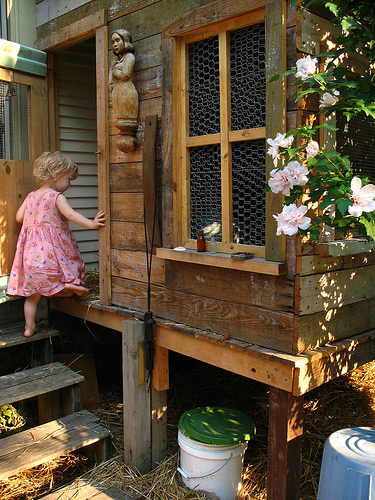

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


1001773457_577c3a7d70


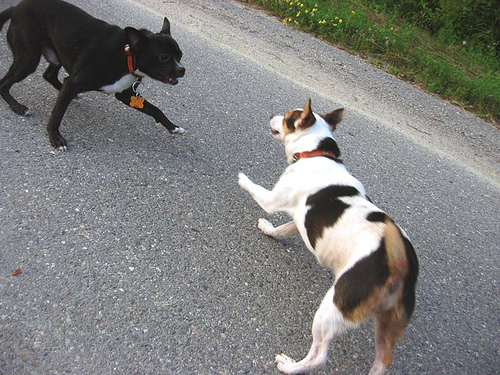

['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']




In [10]:
for i in list(descriptions.keys())[:2]:
    print(i)
    display(Image.open("./IC/Flickr8k_Dataset/{}.jpg".format(i)))
    print(descriptions[i])
    print("\n")

In [11]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [12]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [13]:
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [14]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [15]:
f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [16]:
f = open("./descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [17]:
vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [18]:
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [19]:
import collections

counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [20]:
len(all_vocab)

1845

In [21]:
f = open("./IC/Flickr8k_text/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [22]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [23]:
f = open("./IC/Flickr8k_text/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [24]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [25]:
train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [26]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

![](model.jpg)

In [27]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

In [28]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50

In [29]:
model_new = Model(model.input, model.layers[-2].output)

In [30]:
images = "./IC/Flickr8k_Dataset/"

In [31]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [32]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [34]:
start=time()

encoding_train = {}

for ix, img in enumerate(train):
    img = "./IC/Flickr8k_Dataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    if ix%100==0:
        print("Encoding image- "+ str(ix)) 
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Encoding image- 1000
Encoding image- 1100
Encoding image- 1200
Encoding image- 1300
Encoding image- 1400
Encoding image- 1500
Encoding image- 1600
Encoding image- 1700
Encoding image- 1800
Encoding image- 1900
Encoding image- 2000
Encoding image- 2100
Encoding image- 2200
Encoding image- 2300
Encoding image- 2400
Encoding image- 2500
Encoding image- 2600
Encoding image- 2700
Encoding image- 2800
Encoding image- 2900
Encoding image- 3000
Encoding image- 3100
Encoding image- 3200
Encoding image- 3300
Encoding image- 3400
Encoding image- 3500
Encoding image- 3600
Encoding image- 3700
Encoding image- 3800
Encoding image- 3900
Encoding image- 4000
Encoding image- 4100
Encoding image- 4200
Encoding image- 4300
Encoding image- 4400
Encoding image- 4500
Encoding image- 4600
Encoding image- 4700
Enco

In [35]:
with open("./IC/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [36]:
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "./IC/Flickr8k_Dataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Time taken in seconds = 235.14462518692017


In [37]:
with open("./IC/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [38]:
with open("./IC/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [39]:
with open("./IC/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [40]:
ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [41]:
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [42]:
vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [43]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [44]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [45]:
f = open("./IC/glove.6B.50d.txt", encoding='utf8')

In [46]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

In [47]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [48]:
embedding_output.shape

(1848, 50)

In [49]:
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [50]:
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [51]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False


In [52]:
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])

In [53]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [83]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./IC/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 835s 417ms/step - loss: 3.2785 - accuracy: 0.3115
Epoch 1/1
2000/2000 [==============================] - 779s 389ms/step - loss: 3.1076 - accuracy: 0.3215
Epoch 1/1
2000/2000 [==============================] - 728s 364ms/step - loss: 3.0087 - accuracy: 0.3293
Epoch 1/1
2000/2000 [==============================] - 757s 378ms/step - loss: 2.9423 - accuracy: 0.3351
Epoch 1/1
2000/2000 [==============================] - 931s 465ms/step - loss: 2.8841 - accuracy: 0.3407
Epoch 1/1
2000/2000 [==============================] - 8612s 4s/step - loss: 2.8401 - accuracy: 0.3453
Epoch 1/1
2000/2000 [==============================] - 734s 367ms/step - loss: 2.8007 - accuracy: 0.3498
Epoch 1/1
2000/2000 [==============================] - 736s 368ms/step - loss: 2.7638 - accuracy: 0.3531
Epoch 1/1
2000/2000 [==============================] - 1796s 898ms/step - loss: 2.7354 - accuracy: 0.3553
Epoch 1/1
2000/2000 [==============================] - 7

In [54]:
model = load_model("./IC/model_0.h5")

In [55]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break  
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

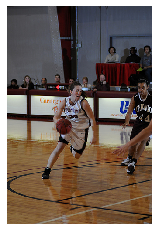

two men in white outfits are playing basketball


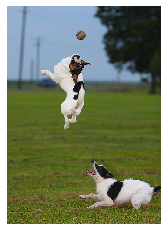

dog jumps over the grass


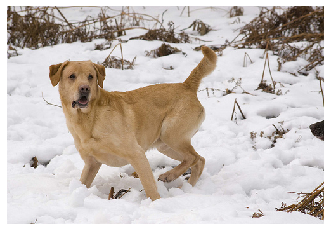

dog is running through snow


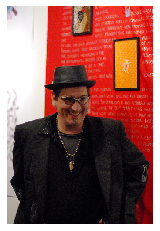

man in black shirt and black shirt is standing in front of an old


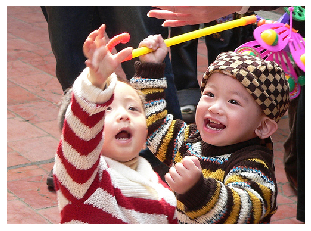

man in red shirt and black shirt is holding the camera


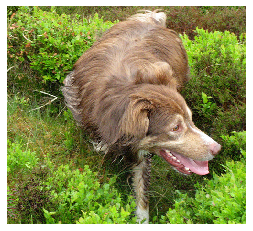

dog is running through the grass


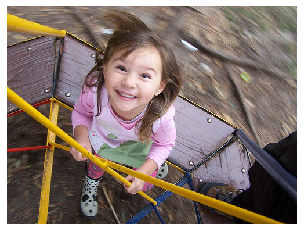

boy in red shirt is sitting on bench


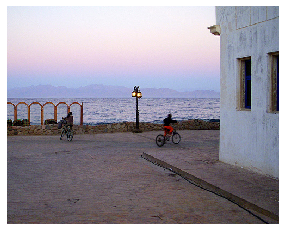

man in red shirt is standing on the beach


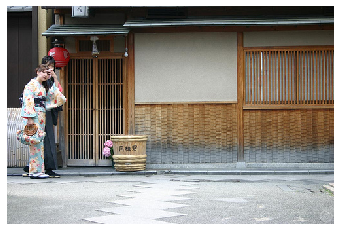

man in black shirt and jeans is standing on the sidewalk


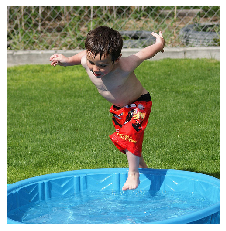

boy in blue bathing suit is playing with ball in the air


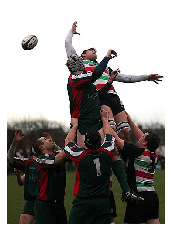

hockey player in white is being tackled


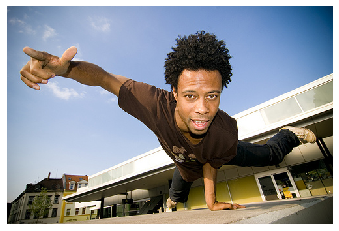

man in black shirt is jumping on the edge of the ocean


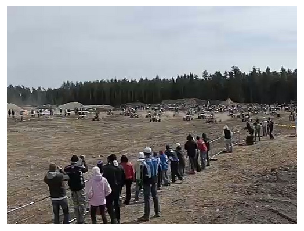

group of people are walking through the countryside


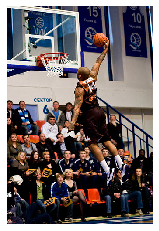

the hockey player is being tackled the ball


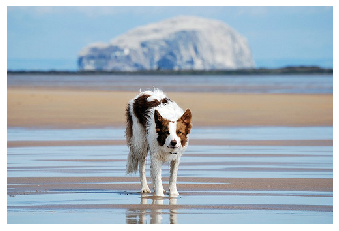

dog running on beach


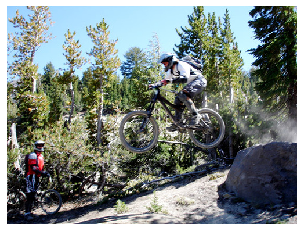

man in green helmet is riding bike down hill


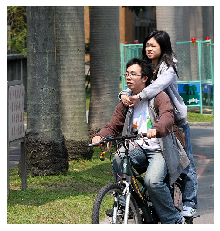

man in black shirt and black shirt is standing on the sidewalk


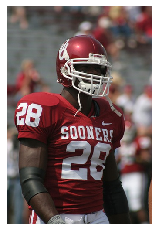

football player in red uniform is being tackled by player in red


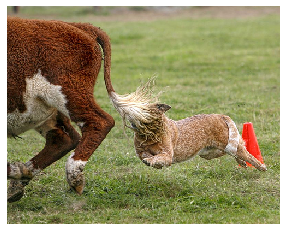

dog is running on the grass


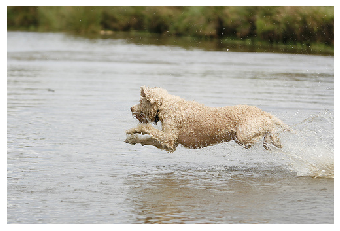

dog running on beach


In [59]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)
    
    